### Objectives of this notebook
<ul>
    <li>Implementing both k means and hierarchical Agglomerative clustering and performing cluster analysis </li>
    <li>Using matplotlib and seaborn and drawing plots for Exploratory Data Analysis</li>
    <li>Using evaluation metrics for unsupervised learning and evaluating our model </li>
    
</ul>

## Dataset(Real world):
We will use cluster analysis to generate a big picture model of the weather at a local station using a minute-graunlarity data. In this dataset, we have in the order of millions records. How do we create clusters out of them to segment out similar weather conditions?

This data comes from a weather station located in San Diego, California. The weather station is equipped with sensors that capture weather-related measurements such as air temperature, air pressure, and relative humidity. Data was collected for a period of three years, from September 2011 to September 2014, to ensure that sufficient data for different seasons and weather conditions is captured.

The minute weather dataset contains raw sensor measurements captured at one-minute intervals.
Each row, or sample, consists of the following variables:

* **rowID:** 	unique number for each row	(*Unit: NA*)
* **hpwren_timestamp:**	timestamp of measure	(*Unit: year-month-day hour:minute:second*)
* **air_pressure:** air pressure measured at the timestamp	(*Unit: hectopascals*)
* **air_temp:**	air temperature measure at the timestamp	(*Unit: degrees Fahrenheit*)
* **avg_wind_direction:**	wind direction averaged over the minute before the timestamp	(*Unit: degrees, with 0 means coming from the North, and increasing clockwise*)
* **avg_wind_speed:**	wind speed averaged over the minute before the timestamp	(*Unit: meters per second*)
* **max_wind_direction:**	highest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and increasing clockwise*)
* **max_wind_speed:**	highest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **min_wind_direction:**	smallest wind direction in the minute before the timestamp	(*Unit: degrees, with 0 being North and inceasing clockwise*)
* **min_wind_speed:**	smallest wind speed in the minute before the timestamp	(*Unit: meters per second*)
* **rain_accumulation:**	amount of accumulated rain measured at the timestamp	(*Unit: millimeters*)
* **rain_duration:**	length of time rain has fallen as measured at the timestamp	(*Unit: seconds*)
* **relative_humidity:**	relative humidity measured at the timestamp	(*Unit: percent*)

In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.metrics import silhouette_score,davies_bouldin_score
from sklearn.preprocessing import StandardScaler,normalize,RobustScaler,MinMaxScaler
import scipy.cluster.hierarchy as shc
import collections
from sklearn.decomposition import PCA, KernelPCA,TruncatedSVD
%matplotlib inline 

### Read the dataset and display some rows

In [2]:
df =pd.read_csv('minute_weather.csv')
df

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,rain_accumulation,rain_duration,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,NaN,NaN,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,0.0,0.0,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,0.0,0.0,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,0.0,0.0,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,0.0,0.0,58.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587252,1587252,2014-09-10 23:55:29,915.9,74.66,1.0,1.8,11.0,2.1,357.0,1.6,0.0,0.0,46.3
1587253,1587253,2014-09-10 23:56:29,915.9,74.66,9.0,1.6,19.0,1.8,353.0,1.4,0.0,0.0,46.2
1587254,1587254,2014-09-10 23:57:29,915.9,74.66,15.0,1.7,42.0,2.3,353.0,1.2,0.0,0.0,46.3
1587255,1587255,2014-09-10 23:58:29,915.9,74.66,8.0,1.8,24.0,2.2,355.0,1.4,0.0,0.0,46.2


### Data Preprocessing:

In [3]:
#We drop rain_duration and rain_accumulation columns because they are mostly zero
df.drop(columns = ['rain_duration','rain_accumulation'],inplace = True)
df

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,58.8
...,...,...,...,...,...,...,...,...,...,...,...
1587252,1587252,2014-09-10 23:55:29,915.9,74.66,1.0,1.8,11.0,2.1,357.0,1.6,46.3
1587253,1587253,2014-09-10 23:56:29,915.9,74.66,9.0,1.6,19.0,1.8,353.0,1.4,46.2
1587254,1587254,2014-09-10 23:57:29,915.9,74.66,15.0,1.7,42.0,2.3,353.0,1.2,46.3
1587255,1587255,2014-09-10 23:58:29,915.9,74.66,8.0,1.8,24.0,2.2,355.0,1.4,46.2


In [4]:
df.info() #Lets inspect our dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587257 entries, 0 to 1587256
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   rowID               1587257 non-null  int64  
 1   hpwren_timestamp    1587257 non-null  object 
 2   air_pressure        1587257 non-null  float64
 3   air_temp            1587257 non-null  float64
 4   avg_wind_direction  1586824 non-null  float64
 5   avg_wind_speed      1586824 non-null  float64
 6   max_wind_direction  1586824 non-null  float64
 7   max_wind_speed      1586824 non-null  float64
 8   min_wind_direction  1586824 non-null  float64
 9   min_wind_speed      1586824 non-null  float64
 10  relative_humidity   1587257 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 133.2+ MB


In [5]:
df.describe()#Lets find the distribution of the dataframe.This method only describes about series of dtype int,float

,rowID,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,relative_humidity
count,1.587257e+06,1.587257e+06,1.587257e+06,1.586824e+06,1.586824e+06,1.586824e+06,1.586824e+06,1.586824e+06,1.586824e+06,1.587257e+06
mean,7.936280e+05,9.168301e+02,6.185144e+01,1.619654e+02,2.774272e+00,1.634030e+02,3.399813e+00,1.668264e+02,2.133130e+00,4.760837e+01
std,4.582018e+05,3.051593e+00,1.183362e+01,9.520812e+01,2.060758e+00,9.236723e+01,2.423167e+00,9.746275e+01,1.745345e+00,2.621454e+01
min,0.000000e+00,9.050000e+02,3.164000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,7.000000e-01
25%,3.968140e+05,9.148000e+02,5.270000e+01,6.200000e+01,1.300000e+00,6.800000e+01,1.600000e+00,7.700000e+01,8.000000e-01,2.470000e+01
50%,7.936280e+05,9.167000e+02,6.224000e+01,1.820000e+02,2.200000e+00,1.870000e+02,2.700000e+00,1.800000e+02,1.600000e+00,4.470000e+01
75%,1.190442e+06,9.187000e+02,7.088000e+01,2.170000e+02,3.800000e+00,2.230000e+02,4.600000e+00,2.120000e+02,3.000000e+00,6.800000e+01
max,1.587256e+06,9.295000e+02,9.950000e+01,3.590000e+02,3.230000e+01,3.590000e+02,3.600000e+01,3.590000e+02,3.200000e+01,9.300000e+01


### Heatmap to identify highly correlated variables:

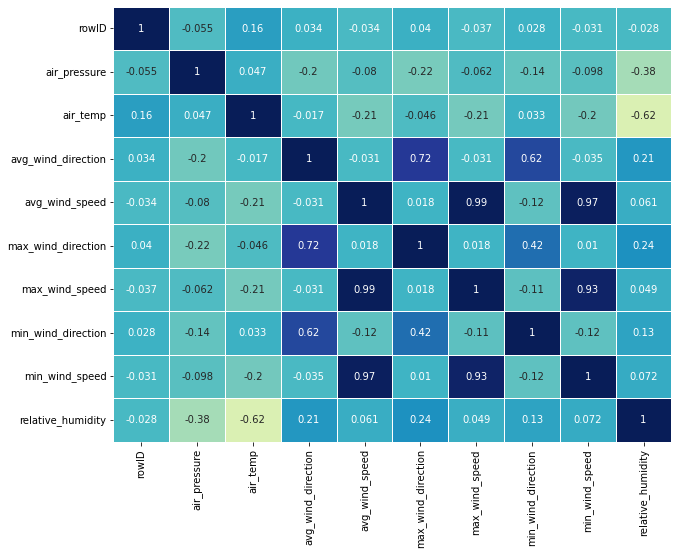

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

We can see that min_wind_speed,max_wind_speed, avg_wind_speed are very highly correlated varibles (having degree of correlation as 0.97 and 0.93) hence we can use only avg_wind_speed which has very high correlation with max and min avg wind speeds for features of our interest. 

### Find duplicates present in dataset

In [7]:
df.duplicated()

0          False
1          False
2          False
3          False
4          False
           ...  
1587252    False
1587253    False
1587254    False
1587255    False
1587256    False
Length: 1587257, dtype: bool

We can see that there are no duplicates present in our dataset

### Detecting outliers by IQR method:

In [8]:
p0 = df.relative_humidity.min()
p100 = df.relative_humidity.max()
q1 = df.relative_humidity.quantile(0.25)
q2 = df.relative_humidity.quantile(0.5)
q3 = df.relative_humidity.quantile(0.75)
iqr = q3-q1

In [9]:
lc = q1 - 1.5*iqr
uc = q3 + 1.5*iqr

In [10]:
print( "p0 = " , p0 ,", p100 = " , p100 ,", lc = " , lc ,", uc = " , uc)

p0 =  0.7 , p100 =  93.0 , lc =  -40.249999999999986 , uc =  132.95


If lc < p0 → There are NO Outliers on the lower side

If uc > p100 → There are NO Outliers on the higher side

We can observe that both the conditions are satisfied by our dataset. So, there are no outliers present in our dataset.

We can also get the pictorial representation and detect any outliers present using Box Plot

<AxesSubplot:>

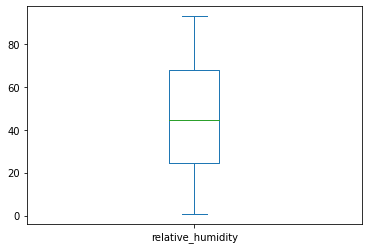

In [11]:
df.relative_humidity.plot(kind ='box')

### Missing values treatment

In [12]:
df.isna().sum()

rowID                   0
hpwren_timestamp        0
air_pressure            0
air_temp                0
avg_wind_direction    433
avg_wind_speed        433
max_wind_direction    433
max_wind_speed        433
min_wind_direction    433
min_wind_speed        433
relative_humidity       0
dtype: int64

In [13]:
print((df.isnull().sum()/df.shape[0])*100.0)

rowID                 0.00000
hpwren_timestamp      0.00000
air_pressure          0.00000
air_temp              0.00000
avg_wind_direction    0.02728
avg_wind_speed        0.02728
max_wind_direction    0.02728
max_wind_speed        0.02728
min_wind_direction    0.02728
min_wind_speed        0.02728
relative_humidity     0.00000
dtype: float64


We can observe that avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed have null values(about 0.027%).As we have very less percentage of null values we can simply drop them.

In [14]:
df.dropna(inplace =True)
df

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,relative_humidity
0,0,2011-09-10 00:00:49,912.3,64.76,97.0,1.2,106.0,1.6,85.0,1.0,60.5
1,1,2011-09-10 00:01:49,912.3,63.86,161.0,0.8,215.0,1.5,43.0,0.2,39.9
2,2,2011-09-10 00:02:49,912.3,64.22,77.0,0.7,143.0,1.2,324.0,0.3,43.0
3,3,2011-09-10 00:03:49,912.3,64.40,89.0,1.2,112.0,1.6,12.0,0.7,49.5
4,4,2011-09-10 00:04:49,912.3,64.40,185.0,0.4,260.0,1.0,100.0,0.1,58.8
...,...,...,...,...,...,...,...,...,...,...,...
1587252,1587252,2014-09-10 23:55:29,915.9,74.66,1.0,1.8,11.0,2.1,357.0,1.6,46.3
1587253,1587253,2014-09-10 23:56:29,915.9,74.66,9.0,1.6,19.0,1.8,353.0,1.4,46.2
1587254,1587254,2014-09-10 23:57:29,915.9,74.66,15.0,1.7,42.0,2.3,353.0,1.2,46.3
1587255,1587255,2014-09-10 23:58:29,915.9,74.66,8.0,1.8,24.0,2.2,355.0,1.4,46.2


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586824 entries, 0 to 1587256
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   rowID               1586824 non-null  int64  
 1   hpwren_timestamp    1586824 non-null  object 
 2   air_pressure        1586824 non-null  float64
 3   air_temp            1586824 non-null  float64
 4   avg_wind_direction  1586824 non-null  float64
 5   avg_wind_speed      1586824 non-null  float64
 6   max_wind_direction  1586824 non-null  float64
 7   max_wind_speed      1586824 non-null  float64
 8   min_wind_direction  1586824 non-null  float64
 9   min_wind_speed      1586824 non-null  float64
 10  relative_humidity   1586824 non-null  float64
dtypes: float64(9), int64(1), object(1)
memory usage: 145.3+ MB


In [16]:
len(df)

1586824

### Down sampling:
The dataset is very large hence we can downsample and only take some datapoints among all present.
To keep memory manageable and to run HAC faster let us take only some part of the dataset

In [17]:
rand_id = np.random.choice(len(df),7000)
sample_df = df.loc[df['rowID'].isin(rand_id)]
sample_df

,rowID,hpwren_timestamp,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,relative_humidity
321,321,2011-09-10 05:21:49,911.4,64.94,82.0,0.7,95.0,0.9,63.0,0.5,44.3
467,467,2011-09-10 07:47:49,912.2,53.96,178.0,1.0,190.0,1.2,163.0,0.6,90.1
540,540,2011-09-10 09:00:49,912.5,55.22,61.0,2.0,71.0,2.3,44.0,1.4,86.3
818,818,2011-09-10 13:38:49,913.2,64.22,237.0,3.0,254.0,4.2,221.0,1.2,62.7
1129,1129,2011-09-10 18:49:49,913.4,57.74,207.0,2.7,221.0,3.1,196.0,2.2,80.5
...,...,...,...,...,...,...,...,...,...,...,...
1585629,1585629,2014-09-09 20:52:29,916.1,68.18,4.0,2.0,14.0,2.3,357.0,1.5,45.0
1585671,1585671,2014-09-09 21:34:29,916.3,68.36,348.0,0.2,1.0,0.3,338.0,0.1,35.0
1585785,1585785,2014-09-09 23:28:29,916.4,68.00,55.0,1.0,61.0,1.2,49.0,0.9,37.7
1586086,1586086,2014-09-10 04:29:29,915.4,67.46,34.0,1.4,47.0,1.7,18.0,1.1,63.3


In [18]:
sample_df.drop(columns = ['rowID','hpwren_timestamp'], inplace = True)
sample_df

C:\Users\lalit\AppData\Local\Temp\ipykernel_1948\897907050.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_df.drop(columns = ['rowID','hpwren_timestamp'], inplace = True)


,air_pressure,air_temp,avg_wind_direction,avg_wind_speed,max_wind_direction,max_wind_speed,min_wind_direction,min_wind_speed,relative_humidity
321,911.4,64.94,82.0,0.7,95.0,0.9,63.0,0.5,44.3
467,912.2,53.96,178.0,1.0,190.0,1.2,163.0,0.6,90.1
540,912.5,55.22,61.0,2.0,71.0,2.3,44.0,1.4,86.3
818,913.2,64.22,237.0,3.0,254.0,4.2,221.0,1.2,62.7
1129,913.4,57.74,207.0,2.7,221.0,3.1,196.0,2.2,80.5
...,...,...,...,...,...,...,...,...,...
1585629,916.1,68.18,4.0,2.0,14.0,2.3,357.0,1.5,45.0
1585671,916.3,68.36,348.0,0.2,1.0,0.3,338.0,0.1,35.0
1585785,916.4,68.00,55.0,1.0,61.0,1.2,49.0,0.9,37.7
1586086,915.4,67.46,34.0,1.4,47.0,1.7,18.0,1.1,63.3


In [19]:
features = ['air_pressure', 'air_temp', 'max_wind_direction','avg_wind_direction','min_wind_direction', 'avg_wind_speed', 'relative_humidity']
#Taking only features of interest for clustering

In [20]:
sample_df = sample_df[features]
sample_df

,air_pressure,air_temp,max_wind_direction,avg_wind_direction,min_wind_direction,avg_wind_speed,relative_humidity
321,911.4,64.94,95.0,82.0,63.0,0.7,44.3
467,912.2,53.96,190.0,178.0,163.0,1.0,90.1
540,912.5,55.22,71.0,61.0,44.0,2.0,86.3
818,913.2,64.22,254.0,237.0,221.0,3.0,62.7
1129,913.4,57.74,221.0,207.0,196.0,2.7,80.5
...,...,...,...,...,...,...,...
1585629,916.1,68.18,14.0,4.0,357.0,2.0,45.0
1585671,916.3,68.36,1.0,348.0,338.0,0.2,35.0
1585785,916.4,68.00,61.0,55.0,49.0,1.0,37.7
1586086,915.4,67.46,47.0,34.0,18.0,1.4,63.3


### Feature Scaling:

It is the final step in data preprocessing. In feature scaling we put all our variables in same range so that one variable doesnot dominate the other.We have 4 feature scaling methods.
1. Standard scaler
2. Min Max Scaler
3. Robust Scaler
4. Normalizer

We will explore first three methods in this notebook and find out which one performs better for our dataset.  

### Standard Scaler:

It resizes the distribution to have mean 0 and unit variance

In [21]:
X = StandardScaler().fit_transform(sample_df)
X

array([[-1.7600764 ,  0.26312084, -0.74617646, ..., -1.07640569,
        -1.00330497, -0.13636408],
       [-1.49908826, -0.64631985,  0.28729986, ..., -0.0414829 ,
        -0.85800936,  1.60158126],
       [-1.40121771, -0.54195781, -1.00726522, ..., -1.27304102,
        -0.37369064,  1.45738492],
       ...,
       [-0.12890051,  0.51657152, -1.1160522 , ..., -1.22129488,
        -0.85800936, -0.38681036],
       [-0.45513569,  0.47184493, -1.26835397, ..., -1.54212095,
        -0.66428187,  0.58461761],
       [-0.12890051,  1.05329062, -1.74701669, ...,  1.87312427,
        -0.76114561, -0.55377454]])

### Robust Scaler:

Scale features using statistics that are robust to outliers. This Scaler removes the median and scales the data according to the quantile range (defaults to IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile).

In [22]:
scaler = RobustScaler()
rob_x = scaler.fit_transform(sample_df)
rob_x

array([[-1.35897436,  0.14423077, -0.6       , ..., -0.9       ,
        -0.57692308, -0.01612903],
       [-1.15384615, -0.44230769,  0.01290323, ..., -0.13076923,
        -0.46153846,  1.03917051],
       [-1.07692308, -0.375     , -0.75483871, ..., -1.04615385,
        -0.07692308,  0.9516129 ],
       ...,
       [-0.07692308,  0.30769231, -0.81935484, ..., -1.00769231,
        -0.46153846, -0.16820276],
       [-0.33333333,  0.27884615, -0.90967742, ..., -1.24615385,
        -0.30769231,  0.42165899],
       [-0.07692308,  0.65384615, -1.19354839, ...,  1.29230769,
        -0.38461538, -0.26958525]])

### Minmax Scaler:

It rescales data from the original range so that all values are within the new range of 0 and 1.It does not change the distribution of original dataset

In [23]:
scaler = MinMaxScaler()
min_x = scaler.fit_transform(sample_df)
min_x

array([[0.27876106, 0.50140056, 0.26462396, ..., 0.17548747, 0.03870968,
        0.46238938],
       [0.31415929, 0.33053221, 0.52924791, ..., 0.454039  , 0.05806452,
        0.96902655],
       [0.32743363, 0.35014006, 0.19777159, ..., 0.12256267, 0.12258065,
        0.92699115],
       ...,
       [0.5       , 0.54901961, 0.16991643, ..., 0.13649025, 0.05806452,
        0.38938053],
       [0.45575221, 0.54061625, 0.13091922, ..., 0.05013928, 0.08387097,
        0.67256637],
       [0.5       , 0.64985994, 0.00835655, ..., 0.96935933, 0.07096774,
        0.34070796]])

### Principal Component Analysis:

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

In [24]:
pca = PCA()
#Transform the data
df_pca = pca.fit_transform(X)
print(np.shape(df_pca))
df_pca

(6981, 7)


array([[-0.91878122,  0.37826533, -0.56481021, ..., -0.21901997,
         0.51749503,  0.08985377],
       [ 1.32271683,  1.12808753, -1.11151023, ..., -0.17585723,
        -0.11373328,  0.04068561],
       [-0.65363543,  2.02634422, -0.84460876, ..., -0.11203041,
        -0.31381547,  0.2226488 ],
       ...,
       [-1.93584057,  0.01256594, -0.64706425, ..., -0.25358669,
        -0.00416141,  0.14523688],
       [-1.82433476,  0.85237304, -0.76663309, ..., -0.31320699,
        -0.60535107,  0.24380147],
       [ 0.69119461, -1.98038722, -0.44181603, ...,  2.1436536 ,
         0.08678517,  1.87128995]])

### Kernel Principal Component Analysis:

Non-linear dimensionality reduction through the use of kernels like ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine'

In [25]:
kernel_pca = KernelPCA(n_components=3,kernel='linear')
kernel_pca_df = kernel_pca.fit_transform(X)
kernel_pca_df

array([[-0.91878122,  0.37826533, -0.56481021],
       [ 1.32271683,  1.12808753, -1.11151023],
       [-0.65363543,  2.02634422, -0.84460876],
       ...,
       [-1.93584057,  0.01256594, -0.64706425],
       [-1.82433476,  0.85237304, -0.76663309],
       [ 0.69119461, -1.98038722, -0.44181603]])

### Truncated SVD:

This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition.

In [26]:
trun_svd = TruncatedSVD(n_components = 2)

Find number of clusters suitable for our dataset using Silhouette Coefficient

Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

Silhouette Score = (b-a)/max(a,b)

where

a= average intra-cluster distance i.e the average distance between each point within a cluster.

b= average inter-cluster distance i.e the average distance between all clusters.

1: Means clusters are well apart from each other and clearly distinguished.

0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.

-1: Means clusters are assigned in the wrong way.


### Assumptions of K-Means:

Before we go on just implementing K-Means algorithm I would suggest to look into assumptions made by the model.
1. k-means assumes the variance of the distribution of each attribute (variable) is spherical;
2. all variables have the same variance;
3. the prior probability for all k clusters is the same, i.e., each cluster has roughly equal number of observations;

If anyone of the assumptions fail k-means will fail.
 

In [27]:
k_means = KMeans(n_clusters=10,init ='k-means++',verbose =0,max_iter = 380)
#Run the  kmeans clustering algorithm method = kmeans++ chooses centroids in a way which speeds up convergence
model = k_means.fit(X)

In [28]:
#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)

In [29]:
labels = k_means.labels_
silhouette_score(X,labels,metric= 'euclidean')

0.23428444853216873

Two values are of importance here — distortion and inertia. Distortion is the average of the euclidean squared distance from the centroid of the respective clusters. Inertia is the sum of squared distances of samples to their closest cluster centre.

### Elbow plot:
In the Elbow method, we are actually varying the number of clusters ( K ) from 1 – 10. For each value of K, we are calculating WCSS ( Within-Cluster Sum of Square ). WCSS is the sum of squared distance between each point and the centroid in a cluster. When we plot the WCSS with the K value, the plot looks like an Elbow. As the number of clusters increases, the WCSS value will start to decrease. WCSS value is largest when K = 1. When we analyze the graph we can see that the graph will rapidly change at a point and thus creating an elbow shape. From this point, the graph starts to move almost parallel to the X-axis. The K value corresponding to this point is the optimal K value or an optimal number of clusters.

In [30]:
#for each value of k, we can initialise k_means and use inertia to identify the sum of squared distances of samples to the nearest cluster centre
sum_of_squared_distances = []
K = range(1,12)
for k in range(1,12):
    k_means = KMeans(n_clusters=k,init = 'k-means++')
    model = k_means.fit(X)
    sum_of_squared_distances.append(k_means.inertia_)

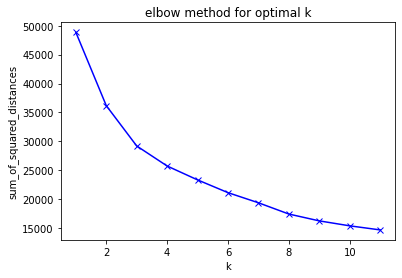

In [31]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

We can see that optimal value of k where elbow shape is formed is k =4

In [32]:
kmean = KMeans(n_clusters = 4)
df_pca = pca.fit_transform(X)
model = kmean.fit(df_pca)
y_hc = kmean.predict(df_pca)
labels = kmean.labels_
print("scores of pca  with StandardScaler")
print('Silhoutte score of kmean is ' , silhouette_score(df_pca, labels))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pca, labels))
df_pca = pca.fit_transform(min_x)
model = kmean.fit(df_pca)
y_h = kmean.fit_predict(df_pca)
labels_kmean = kmean.labels_
print("scores of pca with MinMaxScaler")
print('Silhoutte score of kmean is ' , silhouette_score(df_pca, labels_kmean))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pca, labels_kmean))
df_pca = pca.fit_transform(rob_x)
model = kmean.fit(df_pca)
y_min = kmean.fit_predict(df_pca)
labels_kmean = kmean.labels_
print("scores of pca with RobustScaler")
print('Silhoutte score of kmean is ' , silhouette_score(df_pca, labels_kmean))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pca, labels_kmean))
df_pca = kernel_pca.fit_transform(X)
model = kmean.fit(df_pca)
y_min = kmean.fit_predict(df_pca)
labels_kmean = kmean.labels_
print("scores of kernel pca with StandardScaler")
print('Silhoutte score of kmean is ' , silhouette_score(df_pca, labels_kmean))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pca, labels_kmean))
df_pcade = kernel_pca.fit_transform(min_x)
model_mine = kmean.fit(df_pcade)
y_hce = kmean.fit_predict(df_pcade)
labels_kmean_min = kmean.labels_
print("scores of kernel pca with MinMaxScaler")
print('Silhoutte score of kmean is ' , silhouette_score(df_pcade, labels_kmean_min))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pcade, labels_kmean_min))
df_pca = kernel_pca.fit_transform(rob_x)
model = kmean.fit(df_pca)
y_min = kmean.fit_predict(df_pca)
labels_kmean = kmean.labels_
print("scores of kernel pca with RobustScaler")
print('Silhoutte score of kmean is ' , silhouette_score(df_pca, labels_kmean))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pca, labels_kmean))
df_pca = trun_svd.fit_transform(X)
model = kmean.fit(df_pca)
y_min = kmean.fit_predict(df_pca)
labels_kmean = kmean.labels_
print("scores of truncated svd with StandardScaler")
print('Silhoutte score of kmean is ' , silhouette_score(df_pca, labels_kmean))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pca, labels_kmean))
df_pcad = trun_svd.fit_transform(min_x)
model_min = kmean.fit(df_pcad)
y_hc = kmean.fit_predict(df_pcad)
labels_kmean_min = kmean.labels_
print("scores of truncated svd with MinMaxScaler")
print('Silhoutte score of kmean is ' , silhouette_score(df_pcad, labels_kmean_min))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pcad, labels_kmean_min))
df_pca = trun_svd.fit_transform(rob_x)
model = kmean.fit(df_pca)
y_min = kmean.fit_predict(df_pca)
labels_kmean = kmean.labels_
print("scores of truncated svd with RobustScaler")
print('Silhoutte score of kmean is ' , silhouette_score(df_pca, labels_kmean))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pca, labels_kmean))

scores of pca  with StandardScaler
Silhoutte score of kmean is  0.27098086224020884
davies bouldin score of kmean is  1.4225561362395358
scores of pca with MinMaxScaler
Silhoutte score of kmean is  0.34849957721572256
davies bouldin score of kmean is  1.063210646684248
scores of pca with RobustScaler
Silhoutte score of kmean is  0.2477199751016768
davies bouldin score of kmean is  1.4766813923910407
scores of kernel pca with StandardScaler
Silhoutte score of kmean is  0.3407303240716901
davies bouldin score of kmean is  1.0535858967910139
scores of kernel pca with MinMaxScaler
Silhoutte score of kmean is  0.45441309372140615
davies bouldin score of kmean is  0.8430974116344568
scores of kernel pca with RobustScaler
Silhoutte score of kmean is  0.3413835161115402
davies bouldin score of kmean is  0.9994492044522848
scores of truncated svd with StandardScaler
Silhoutte score of kmean is  0.41328993920044776
davies bouldin score of kmean is  0.8660153955535671
scores of truncated svd with

### Visualizing the clusters formed:


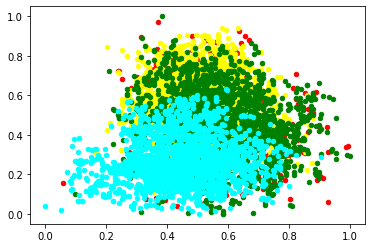

In [33]:
min_x = np.array(min_x)
plt.scatter(min_x[y_hce==0, 0], min_x[y_hce==0, 1], s=20, c='red', label ='Cluster 1')
plt.scatter(min_x[y_hce==1, 0], min_x[y_hce==1, 1], s=20, c='yellow', label ='Cluster 2')
plt.scatter(min_x[y_hce==2, 0], min_x[y_hce==2, 1], s=20, c='green', label ='Cluster 3')
plt.scatter(min_x[y_hce==3, 0], min_x[y_hce==3, 1], s=20, c='cyan', label ='Cluster 4')
plt.show()

### Create plots to understand clusters formed:

In [34]:
df_pca = pca.fit_transform(min_x)
model = kmean.fit(df_pca)
y_min = kmean.fit_predict(df_pca)
labels_kmean = kmean.labels_
print("scores of pca with MinMaxScaler")
print('Silhoutte score of kmean is ' , silhouette_score(df_pca, labels_kmean))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pca, labels_kmean))

scores of pca with MinMaxScaler
Silhoutte score of kmean is  0.34848166459415214
davies bouldin score of kmean is  1.0635860305184126


In [35]:
# Function that creates a DataFrame with a column for Cluster Number

def pd_centers(featuresUsed, centers):
    colNames = list(featuresUsed)
    colNames.append('prediction')

    # Zip with a column called 'prediction' (index)
    Z = [np.append(A, index) for index, A in enumerate(centers)]

    # Convert to pandas data frame for plotting
    P = pd.DataFrame(Z, columns=colNames)
    P['prediction'] = P['prediction'].astype(int)
    return P

In [36]:
# Function that creates Parallel Plots
from itertools import cycle, islice
from pandas.plotting import parallel_coordinates

def parallel_plot(data):
    my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(data)))
    plt.figure(figsize=(15,8)).gca().axes.set_ylim([-3,+3])
    parallel_coordinates(data, 'prediction', color = my_colors, marker='o')

In [37]:
centers = model.cluster_centers_

In [38]:
P = pd_centers(features, centers)
P

,air_pressure,air_temp,max_wind_direction,avg_wind_direction,min_wind_direction,avg_wind_speed,relative_humidity,prediction
0,-0.203315,0.126014,0.616840,-0.042715,0.058747,-0.280452,0.002522,0
1,0.173454,0.272241,-0.045300,-0.016278,-0.004278,0.022081,-0.000795,1
2,-0.552758,-0.078820,-0.065967,0.014289,-0.022036,0.023722,0.001771,2
3,0.317895,-0.287152,-0.008340,0.015651,0.013104,0.007530,-0.001097,3


### Dry days

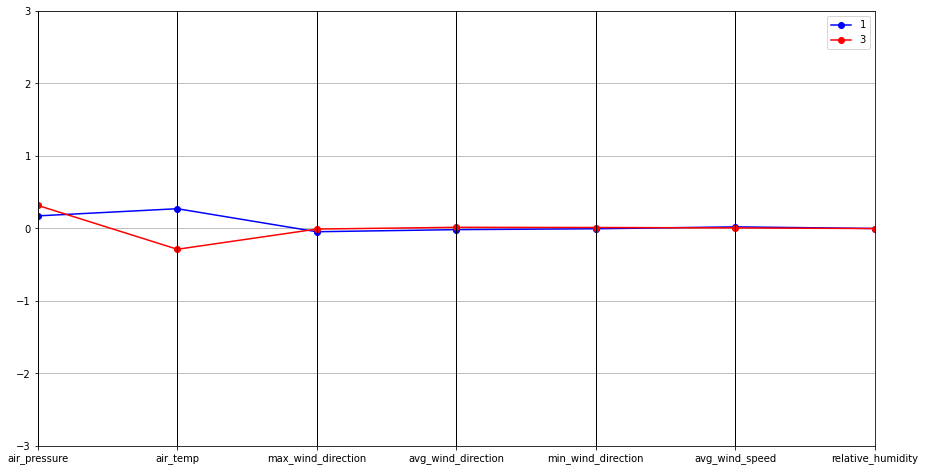

In [39]:
parallel_plot(P[P['relative_humidity'] < 0])

### Warm days

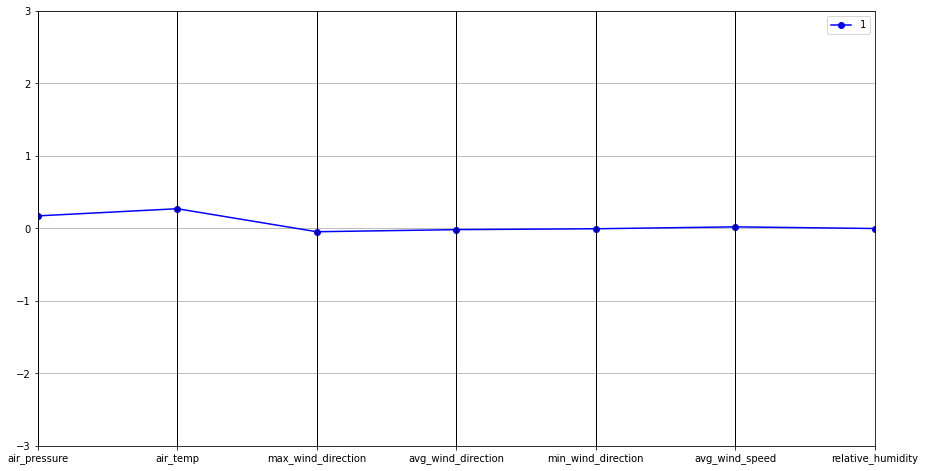

In [40]:
parallel_plot(P[P['air_temp'] > 0.2])

### Cool days

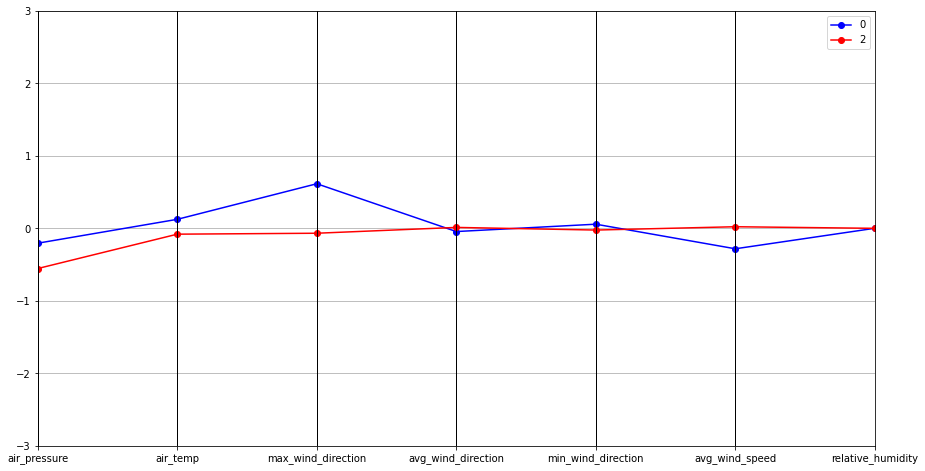

In [41]:
parallel_plot(P[(P['relative_humidity'] > 0) & (P['air_temp'] < 0.2)])

   All the cluster centroids which fall under a category sunny or cool or dry indicates that the cluster points of particular centroid exhibit sunny or cool or dry nature .

### Drawbacks of K-Means clustering:
We have to decide number of clusters in before hand and it always tries to make clusters of same size.
Lets implement another clustering algorithm(Hierarchical Clustering)

## Hierarchical Agglomerative clustering(HAC):

   In this algorithm we assign each point to individual cluster and at each iteration we merge closest pair of clusters and repeat this process until a single cluster is left. 
   How do we decide which points are similar?Take distance between centroids of clusters and the points having least distance can be merged.It is a distance-based algorithm. We store all the distances between any two points in a proximity matrix. 
    
### Choosing number of clusters:
   To get number of clusters in HAC we use dendrogram. A dendrogram is a tree like structure which records sequence of merges/splits.We set a threshold and draw a line. We choose it in such a way that it cuts the tallest vertical line. Total number of clusters will be number of vertical lines intersected by threshold.

Lets go ahead and implement what we have learnt. 


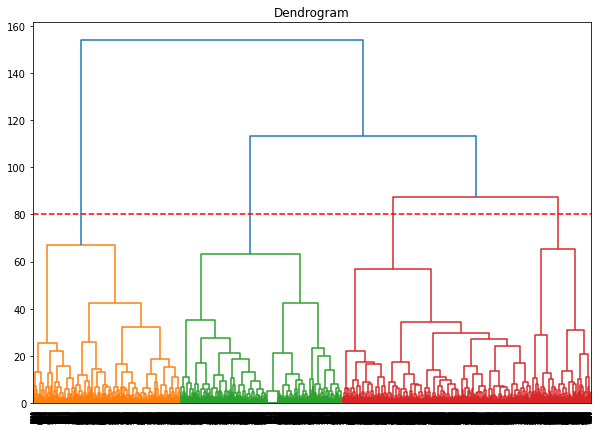

In [42]:
plt.figure(figsize =(10,7))
plt.title('Dendrogram')
dend = shc.dendrogram(shc.linkage(X, method='ward',metric ='euclidean'))
plt.axhline(y=80, color='r', linestyle='--')
plt.show()

### Choosing threshold for dendogram:



In [43]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
df_pca = pca.fit_transform(X)
y = cluster.fit_predict(df_pca)
labels_hac = cluster.labels_
print("scores of pca with StandardScaler")
print('Silhoutte score of Hierarchical is ' , silhouette_score(X, labels_hac))
print('davies bouldin score of Hierarchical is ' , davies_bouldin_score(X, labels_hac))
df_pca = pca.fit_transform(min_x)
y = cluster.fit_predict(df_pca)
labels_hac = cluster.labels_
print("scores of pca with MinMaxScaler")
print('Silhoutte score of Hierarchical is ' , silhouette_score(df_pca, labels_hac))
print('davies bouldin score of Hierarchical is ' , davies_bouldin_score(df_pca, labels_hac))
df_pca = pca.fit_transform(rob_x)
y = cluster.fit_predict(df_pca)
labels_hac = cluster.labels_
print("scores of pca with RobustScaler")
print('Silhoutte score of Hierarchical is ' , silhouette_score(df_pca, labels_hac))
print('davies bouldin score of Hierarchical is ' , davies_bouldin_score(df_pca, labels_hac))
df_pca = kernel_pca.fit_transform(X)
y = cluster.fit_predict(df_pca)
labels_hac = cluster.labels_
print("scores of kernel pca with StandardScaler")
print('Silhoutte score of Hierarchical is ' , silhouette_score(df_pca, labels_hac))
print('davies bouldin score of Hierarchical is ' , davies_bouldin_score(df_pca, labels_hac))
df_pca = kernel_pca.fit_transform(min_x)
y_hc = cluster.fit_predict(df_pca)
labels_hac = cluster.labels_
print("scores of kernel pca with MinMaxScaler")
print('Silhoutte score of Hierarchical is ' , silhouette_score(df_pca, labels_hac))
print('davies bouldin score of Hierarchical is ' , davies_bouldin_score(df_pca, labels_hac))
df_pca = kernel_pca.fit_transform(rob_x)
y = cluster.fit_predict(df_pca)
labels_hac = cluster.labels_
print("scores of kernel pca with RobustScaler")
print('Silhoutte score of Hierarchical is ' , silhouette_score(df_pca, labels_hac))
print('davies bouldin score of Hierarchical is ' , davies_bouldin_score(df_pca, labels_hac))
df_pca = trun_svd.fit_transform(X)
y_h = cluster.fit_predict(df_pca)
labels_hac = cluster.labels_
print("scores of truncated svd with StandardScaler")
print('Silhoutte score of Hierarchical is ' , silhouette_score(df_pca, labels_hac))
print('davies bouldin score of kmean is ' , davies_bouldin_score(df_pca, labels_hac))
df_pcad = trun_svd.fit_transform(min_x)
y_h = cluster.fit_predict(df_pcad)
labels_hac = cluster.labels_
print("scores of truncated svd with MinMaxScaler")
print('Silhoutte score of Hierarchical is ' , silhouette_score(df_pcad, labels_hac))
print('davies bouldin score of Hierarchical is ' , davies_bouldin_score(df_pcad, labels_hac))
df_pca = trun_svd.fit_transform(rob_x)
y = cluster.fit_predict(df_pca)
labels_hac = cluster.labels_
print("scores of truncated svd with RobustScaler")
print('Silhoutte score of Hierarchical is ' , silhouette_score(df_pca, labels_hac))
print('davies bouldin score of Hierarchical is ' , davies_bouldin_score(df_pca, labels_hac))

scores of pca with StandardScaler
Silhoutte score of Hierarchical is  0.24032542358029713
davies bouldin score of Hierarchical is  1.4997315733510441
scores of pca with MinMaxScaler
Silhoutte score of Hierarchical is  0.2968755883540477
davies bouldin score of Hierarchical is  1.2729805371912448
scores of pca with RobustScaler
Silhoutte score of Hierarchical is  0.22962335175833598
davies bouldin score of Hierarchical is  1.4951211286341513
scores of kernel pca with StandardScaler
Silhoutte score of Hierarchical is  0.3166498681331434
davies bouldin score of Hierarchical is  1.0365208564056163
scores of kernel pca with MinMaxScaler
Silhoutte score of Hierarchical is  0.3922168907539009
davies bouldin score of Hierarchical is  0.8976287068012444
scores of kernel pca with RobustScaler
Silhoutte score of Hierarchical is  0.30525520352164903
davies bouldin score of Hierarchical is  0.9573764758543659
scores of truncated svd with StandardScaler
Silhoutte score of Hierarchical is  0.32589560

The results for both K-Means and HAC shows that kernel pca is better as it enables dealing with more complex data patterns, which would not be visible under linear transformations alone.

Order of performance:
**Kernel Pca>Truncted SVD> PCA**

The results also show that **MinMax Scaler** works the best among other feature scaling techniques


The Silhouette score used to study the separation distance between the resulting clusters :kmean with kernel_pca and MinMaxScaler shows best score 0.456.( higher values indicating better clustering)

the Davies-Bouldin score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score and kmean with kernel_pca and MinmaxScaler shows best score 0.83 than HAC .( lower values indicating better clustering)

As we are selecting data points randomly for the dataframe. The numbers may slightly vary but in overall K-means with kernel PCA and Minmax scaling performed the best. 

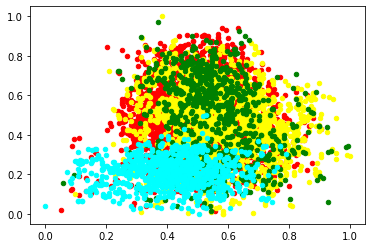

In [44]:
min_x = np.array(min_x)
plt.scatter(min_x[y_hc==0, 0], min_x[y_hc==0, 1], s=20, c='red', label ='Cluster 1')
plt.scatter(min_x[y_hc==1, 0], min_x[y_hc==1, 1], s=20, c='yellow', label ='Cluster 2')
plt.scatter(min_x[y_hc==2, 0], min_x[y_hc==2, 1], s=20, c='green', label ='Cluster 3')
plt.scatter(min_x[y_hc==3, 0], min_x[y_hc==3, 1], s=20, c='cyan', label ='Cluster 4')
plt.show()
